# New York City Taxi Fare Prediction Playground Competition

This is my notebook I used to explore the NYC Taxi Fare dataset. Use this yourself to explore the dataset. If you have question, sent me a message!

Have fun!

Albert van Breemen
27/7/2018

**Update**

2018/08/27
- Corrected error in calculating min/max coordinates. This error has no consequence for the remaining analysis. [Thanks to Pegah]

2018/08/10
- Added visuals to analyse the importance of the direction of a trip

2018/08/08
- Using the insights from this notebook, I trained a model that got a #1 position on 2018/08/07 (LB score 2.88396)
- Added pickup traffic density plots to see how busy it is in Manhatten by the hour

2018/08/04
- Thanks for all the feedback! This notebook is becoming rather long, but there is so much fun stuff to analyse!! ;)
- updated the boundingbox and NYC maps, as one test point was not within the bounding box
- added zoomed in map of NYC
- added hiresolution NYC/Manhattan map plot
- added function to remove datapoints from water
- small update in datapoints per sq miles calculation

2018/07/30
- Corrected 'ewr'/'lgr' typo [Thanks to Lu Mingming]
- Small update `plot_on_map` function
- Converted distances to miles [Thanks to sandy1112]
- Add Taxi pricing rules [Thanks to sandy1112]
- Added density plots (datapoints per sq mile)

2018/07/28 
- Added a graph with estimated drive time for two trips using Google Map Traffic info. This could explain how fare depends on hour of the day.


## Reading data and first exploration


First thing I like to do with a new dataset is to explore the data. This means investigating the number of features, their datatype, their meaning and statistics.

In [ ]:
# load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

As this dataset is huge reading all data would require a lot of memory. Therefore I read a limited number of rows while exploring the data. When my exploration code (e.g. this notebook) is ready I re-run the notebook while reading more rows.

In [ ]:
# read data in pandas dataframe
df_train =  pd.read_csv('../input/train.csv', nrows = 2_000_000, parse_dates=["pickup_datetime"])
# list first few rows (datapoints)
df_train.head()

In [25]:
# check datatypes
df_train.dtypes
df_train.shape

(1999909, 8)

In [22]:
# check statistics of the features
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.999909e+06,1.999909e+06,1.999909e+06,1.999909e+06,1.999909e+06,1.999909e+06
mean,1.134841e+01,-7.252329e+01,3.992968e+01,-7.252415e+01,3.992819e+01,1.684123e+00
std,9.851787e+00,1.286792e+01,7.983332e+00,1.277449e+01,1.032374e+01,1.314976e+00
min,0.000000e+00,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


The following things I notice (while using 500k datapoints):

- The minimal `fare_amount` is negative. As this does not seem to be realistic I will drop them from the dataset.
- Some of the minimum and maximum longitude/lattitude coordinates are way off. These I will also remove from the dataset (I will define a bounding box for the coordinates, see further).
- The average `fare_amount` is about \$11.4 USD with a standard deviation of \$9.9 USD. When building a predictive model we want to be better than $9.9 USD :)

In [16]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 1999909
New size: 1999909


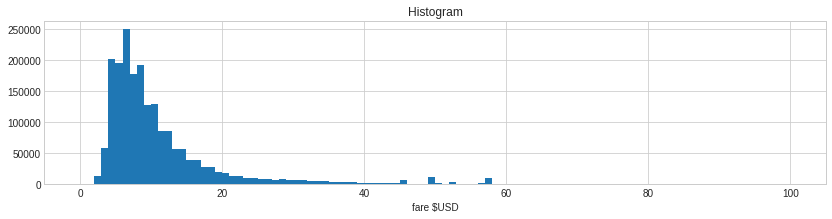

In [17]:
# plot histogram of fare
df_train[df_train.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');
#sns.distplot(a=df_train[df_train.fare_amount<100].fare_amount, kde=False)

In the histogram of the `fare_amount` there are some small spikes between \$40 and \$60. This could indicate some fixed fare price (e.g. to/from airport). This will be explored further below.

## Remove missing data

Always check to see if there is missing data. As this dataset is huge, removing datapoints with missing data probably has no effect on the models beings trained.

In [18]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [19]:
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 1999909
New size: 1999909


## Test data
Read the test data to check the statistics and compare with the training set.

In [20]:
# read data in pandas dataframe
df_test =  pd.read_csv('../input/test.csv')
df_test.head(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [21]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


## Location data

As we're dealing with location data, I want to plot the coordinates on a map. This gives a better view of the data. For this, I use the following website:

- Easy to use map and GPS tool: https://www.gps-coordinates.net/ 
- Calculate distance between locations: https://www.travelmath.com/flying-distance/
- Open street map to grab using bouding box a map: https://www.openstreetmap.org/export#map=8/52.154/5.295

New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

- longitude = -74.0063889
- lattitude = 40.7141667

I define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, I'm sure to train a model for the full pickup/dropoff coordinate range of the test set.

From Open Street Map I grab a map and I drop any datapoint outside this box.

In [26]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [27]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [28]:
help(plt.imread)

Help on function imread in module matplotlib.pyplot:

imread(fname, format=None)
    Read an image from a file into an array.
    
    Parameters
    ----------
    fname : str or file-like
        The image file to read. This can be a filename, a URL or a Python
        file-like object opened in read-binary mode.
    format : str, optional
        The image file format assumed for reading the data. If not
        given, the format is deduced from the filename.  If nothing can
        be deduced, PNG is tried.
    
    Returns
    -------
    imagedata : :class:`numpy.array`
        The image data. The returned array has shape
    
        - (M, N) for grayscale images.
        - (M, N, 3) for RGB images.
        - (M, N, 4) for RGBA images.
    
    Notes
    -----
    Matplotlib can only read PNGs natively. Further image formats are
    supported via the optional dependency on Pillow. Note, URL strings
    are not compatible with Pillow. Check the `Pillow documentation`_
    for mor

In [33]:
import matplotlib.pyplot as plt
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [29]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [ ]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

In [ ]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [ ]:
# plot training data on map
plot_on_map(df_train, BB, nyc_map, s=1, alpha=0.3)

In [ ]:
# plot training data on map zoomed in
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [ ]:
# plot test data on map
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=20)

From the training data scatter plot we see that some locations are in the water. Either these are considered as noise, or we drop them from the dataset. I decided to drop them (see next section).

An other interesting way to visualize the data I learned from this kernel: https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation. By using very small dot sizes the actual streets of New York become visible.

In [ ]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, 
               df[idx].dropoff_latitude,
               c=c[1], s=0.01, alpha=0.5)

In [ ]:
plot_hires(df_train, (-74.1, -73.7, 40.6, 40.9))
plot_hires(df_train, (-74, -73.95, 40.7, 40.8))

## Removing datapoints in water
As can be seen from the map + scatter plots above, some datapoints are located in the water. These are obviously noisy datapoints. To remove these datapoints, I create a boolean land/water map from the NYC map. For this I used Photoshop to threshold on the blue color of the water and to cleanup the map. The resulting map is show below.

In [ ]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

Next, I need to convert longitude/latitude coordinates to xy pixel coordinates. The function lonlat_to_xy implements this transformation. Note that the y coordinate needs to be reversed as the image y-axis is directed from top to bottom.

Once for all datapoints the xy pixel coordinates are calculate a boolean index is calculated using the NYC mask.

In [ ]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [ ]:
pickup_x, pickup_y = lonlat_to_xy(df_train.pickup_longitude, df_train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df_train.dropoff_longitude, df_train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [ ]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Finally I create one function that can be reused to remove datapoints from water.

In [ ]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [ ]:
print('Old size: %d' % len(df_train))
df_train = remove_datapoints_from_water(df_train)
print('New size: %d' % len(df_train))

Now Let's see if all outliers in the water are gone ... :)

In [ ]:
# plot training data
plot_on_map(df_train, BB, nyc_map)


### Datapoint density per sq mile


A scatterplot of the pickup and dropoff locations gives a quick impression of the density. However, it is more accurate to count the number of datapoints per area to visualize the density. The code below counts pickup and dropoff datapoints per sq miles. This gives a better view on the 'hot spots'.

In [ ]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(df_train.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(df_train.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(df_train.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(df_train.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

In [ ]:
# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

axs[1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)

These plots clearly show that the datapoints concentrate around Manhatten and the three airports (JFK, EWS, LGR). There is also a hotspot near Seymour (upper right corner). As I'm not from the US, does somebody has an idea what's so special about this location?


## Pickup traffic density
The density plots of above triggered me to see if I can visualize traffic density by the hour (and year). By counting the number of pickups in an area we should get some impression of the traffic density. The more traffic, the longer it could take to make a drive.

In [ ]:
# add time information
df_train['year'] = df_train.pickup_datetime.apply(lambda t: t.year)
df_train['weekday'] = df_train.pickup_datetime.apply(lambda t: t.weekday())
df_train['hour'] = df_train.pickup_datetime.apply(lambda t: t.hour)

In [ ]:
# some constants needed to calculate pickup traffic density
n_hours = 24
n_weekdays = 7
n_years = 7
n_bins_lon = 30
n_bins_lat = 30

# focus on traffic in Manhattan
BB_traffic = (-74.025, -73.925, 40.7, 40.8)

# define function to calculate pickup traffic density
def calculate_trafic_density(df):
    traffic = np.zeros((n_years, n_weekdays, n_hours, n_bins_lat, n_bins_lon))
    
    # To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
    # This function needs an array with the (location) bins for counting the number of datapoints
    # per bin.
    bins_lon = np.zeros(n_bins_lon+1) # bin
    bins_lat = np.zeros(n_bins_lat+1) # bin
    
    delta_lon = (BB_traffic[1]-BB_traffic[0]) / n_bins_lon # bin longutide width
    delta_lat = (BB_traffic[3]-BB_traffic[2]) / n_bins_lat # bin latitude height
    
    for i in range(n_bins_lon+1):
        bins_lon[i] = BB_traffic[0] + i * delta_lon
    for j in range(n_bins_lat+1):
        bins_lat[j] = BB_traffic[2] + j * delta_lat
    
    # Count per grid bin
    # note: as the density_pickup will be displayed as image, the first index is the y-direction, 
    #       the second index is the x-direction. Also, the y-direction needs to be reversed for
    #       properly displaying (therefore the (n_lat-j) term)
    for y in range(n_years):
        for d in range(n_weekdays):
            for h in range(n_hours):
                idx = (df.year==(2009+y)) & (df.weekday==d) & (df.hour==h)

                # Digitize per longitude, latitude dimension
                inds_pickup_lon = np.digitize(df[idx].pickup_longitude, bins_lon)
                inds_pickup_lat = np.digitize(df[idx].pickup_latitude, bins_lat)

                for i in range(n_bins_lon):
                    for j in range(n_bins_lat):
                        traffic[y, d, h, j, i] = traffic[y, d, h, j, i] + \
                                                 np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==j+1))
    
    return traffic 

# define function to plot pickup traffic density
def plot_traffic(traffic, y, d):
    days = {'monday' : 0, 'tuesday' : 1, 'wednesday' : 2, 'thursday' : 3, 'friday' : 4, 'saturday' : 5, 'sunday' : 6}
    fig, axs = plt.subplots(3,8,figsize=(18,7))
    axs = axs.ravel()
    for h in range(24):
        axs[h].imshow(traffic[y-2009,days[d],h,::-1,:], zorder=1, cmap='coolwarm', clim=(0, traffic.max()))
        axs[h].get_xaxis().set_visible(False)
        axs[h].get_yaxis().set_visible(False)
        axs[h].set_title('h={}'.format(h))
    fig.suptitle("Pickup traffic density, year={}, day={} (max_pickups={})".format(y, d, traffic.max()))

Now, let's calculate the density and visualize the plots. 

NOTE: the quality of the plots depends on the number of datapoints used. This notebook uses by default 500k points, which is not sufficient for good traffic density plots. Increase the number of points and you get better plots.

In [ ]:
traffic = calculate_trafic_density(df_train)

In [ ]:
plot_traffic(traffic, 2009, 'monday')
plot_traffic(traffic, 2009, 'friday')
plot_traffic(traffic, 2009, 'sunday')

Already from these plots we can see the different traffic density patterns by the hour, but also by location. E.g. at sunday h=0-3 hour (saturday night to sunday) there is more traffic than on weekdays. I presume this is from people going out and enjoying the weekend.  Let's also visualize an other year.

In [ ]:
plot_traffic(traffic, 2014, 'monday')
plot_traffic(traffic, 2014, 'friday')
plot_traffic(traffic, 2014, 'sunday')

## Distance and time visualisations

Before building a model I want to test some basic 'intuition':

- The longer the distance between pickup and dropoff location, the higher the fare.
- Some trips, like to/from an airport, are fixed fee. 
- Fare at night is different from day time.

So, let's check.

### The longer the distance between pickup and dropoff location, the higher the fare

To visualize the distance - fare relation we need to calculate the distance of a trip first. 

In [ ]:
# add new column to dataframe with distance in miles
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

df_train.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
df_train.distance_miles.describe()

It seems that most rides are just short rides, with a small peak at ~13 miles. This peak could be due to airport drives.

Let's also see the influence of `passenger_count`.

In [ ]:
df_train.groupby('passenger_count')['distance_miles', 'fare_amount'].mean()

A `passenger_count` of zero seems odd. Perhaps a taxi transporting some goods or an administration error? The latter seems not the case as the `fare_amount` is also significantly lower.

Instead of looking to the `fare_amount` using the 'fare per mile' also provides some insights.

In [ ]:
print("Average $USD/Mile : {:0.2f}".format(df_train.fare_amount.sum()/df_train.distance_miles.sum()))

In [ ]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(df_train.distance_miles, df_train.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (df_train.distance_miles < 15) & (df_train.fare_amount < 100)
axs[1].scatter(df_train[idx].distance_miles, df_train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');

From this plot we notice:

- There are trips with zero distance but with a non-zero fare. Could this be trips from and to the same location? Predicting these fares will be difficult as there is likely not sufficient information in the dataset.
- There are some trips with >50 miles travel distance but low fare. Perhaps these are discounted trips? Or the previously mentioned hotspot near Seymour (see density plots above)?
- The horizontal lines in the right plot might indicate again the fixed fare trips to/from JFK airport.
- Overall there seems to be a (linear) relation between distance and fare with an average rate of +/- 100/20 = 5 \$USD/mile.

Considering the last point, when I google for NYC taxi fare prices I find:

- \$4.00 – \$10.00 for 3km trip (https://www.priceoftravel.com/555/world-taxi-prices-what-a-3-kilometer-ride-costs-in-72-big-cities/)
- Start range: \$2.50 - \$3.30, 1km range: \$1.55 - \$2.98 (https://www.numbeo.com/taxi-fare/in/New-York)
- A detailed description of the taxi prices: http://home.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml
    - Initial charge for most rides (excluding from JFK and other airports) is \$2.50 upon entry. After that there \$0.5 every unit where the unit is defined as 1/5th of a mile or when the Taxicab is travelling 12 Miles an hour or more...since we can't decipher the velocity of the car, I would take 1/5th of a mile as the unit and convert the distance into this unit.
    - \$0.5 of additional surcharge between 8PM - 6AM.
    - Peak hour weekday surcharge of \$1 Monday-Friday between 4PM-8PM.
    - There is a \$0.5 MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
    - There is a \$0.3 Improvement surcharge

Note: the calculated distance in the dataset is from point to point. In reality, the distance measured by road is larger.

In [ ]:
# remove datapoints with distance <0.05 miles
idx = (df_train.distance_miles >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

## Some trips, like to/from an airport, are fixed fee

Another way to explore this data is to check trips to/from well known places. E.g. a trip to JFK airport. Depending on the distance, a trip to an airport is often a fixed price. Let's see.

In [ ]:
# JFK airport coordinates, see https://www.travelmath.com/airport/JFK
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

def plot_location_fare(loc, name, range=1.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    idx = (distance(df_train.pickup_latitude, df_train.pickup_longitude, loc[1], loc[0]) < range)
    df_train[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} miles of {}'.format(range, name))

    idx = (distance(df_train.dropoff_latitude, df_train.dropoff_longitude, loc[1], loc[0]) < range)
    df_train[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, name));
    
plot_location_fare(jfk, 'JFK Airport')

It seems that there are some fixed prices to/from the airport. Also, somebody might have paid way too much ($250??)!

Let's do the same for the other two airports.

In [ ]:
ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA
plot_location_fare(ewr, 'Newark Airport')
plot_location_fare(lgr, 'LaGuardia Airport')

## Fare at night is different from day time

To visualize the relation between time and fare/km three more columns are added to the data: the year, the hour of the day and the fare $USD per KM.

In [ ]:
df_train['fare_per_mile'] = df_train.fare_amount / df_train.distance_miles
df_train.fare_per_mile.describe()

The maximum fare \$USD/mile seem to be very high. This could be due to wrong distance or fare data. On the other hand, let's analyse this somewhat further. In general taxi fare is calculate by

$$
y_{fare} = \theta_0 + \theta_1 \cdot x_{distance} + \theta_2 \cdot x_{duration}
$$

with $\theta_0$ the starting tariff, $x_{distance}$ the distance travelled and $x_{duration}$ the duration of the trip. If we rewrite this we get an expression for the fare per distance:

$$
\frac{y_{fare}}{x_{distance}} = \frac{\theta_0}{x_{distance}} + \theta_1 + \theta_2 \cdot \frac{x_{duration}}{ x_{distance}}
$$

Let's further assume for the shorter trips that $x_{distance} = c \cdot x_{duration}$ with $c$ the average speed, then we get

$$
\frac{y_{fare}}{x_{distance}} = \frac{\theta_0}{x_{distance}} + \theta_1 + \frac{\theta_2}{c} \cdot \frac{x_{duration}}{x_{duration}} = \frac{\theta_0}{x_{distance}} + \theta_1'
$$

with $\theta_1' = \theta_1 + \theta_2 / c$.

Conclusion: the fare per distance is proportional to $1/\text{distance_mile}$. Let's plot the data and a graph.


In [ ]:
idx = (df_train.distance_miles < 3) & (df_train.fare_amount < 100)
plt.scatter(df_train[idx].distance_miles, df_train[idx].fare_per_mile)
plt.xlabel('distance mile')
plt.ylabel('fare per distance mile')

# theta here is estimated by hand
theta = (16, 4.0)
x = np.linspace(0.1, 3, 50)
plt.plot(x, theta[0]/x + theta[1], '--', c='r', lw=2);

Note that the fare per distance has more spread for smaller distances (<0.5 mile) than larger distances. This could be explained as follows:  we measure the distance from point to point and not by road. For smaller distances the difference between these two measurement methods is expected to be larger. This is one aspect I would guess a more advanced model (deep learning NN) would improve upon compared to a linear model.

[30/07/2018] An other reason why the spread for smaller distances is larger could be due to slow traffic at rush hours. Short drives at rush hours vary more in duration.

Let's continue with the time vs fare per distance analysis. Next we use a pandas pivot table to calculate a summary and to plot them.

In [ ]:
# display pivot table
df_train.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile');

It can be clearly seen that the fare $USD/mile varies over the years and over the hours. 

To investigate this further I used Google map to calculate the expected duration of two trips:

- Trip 1 : from Museum of the City of New York to Beacon Theatre, 4.5km, not leaving Manhatten
- Trip 2 : from Times Squared to Maria Hermandez Park, 12km, leaving Times Squared via Queens Midtown Tunnel (Toll road)

Below are the data and graphs. I do see the same type of graph. So, amount of traffic determines the duration of the trip and thus the fare. While the amount of traffic depends on the hour of the day.

In [ ]:
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, \
         13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

# minimum & maximum duration in minutes
trip1_min = [10, 10, 10, 10, 10, 10, 10, 12, 14, 14, 14, 14, \
             14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 10, 10]
trip1_max = [20, 18, 16, 16, 16, 18, 22, 26, 40, 35, 35, 35, \
             35, 35, 35, 40, 35, 30, 28, 28, 26, 26, 24, 24]

trip2_min = [18, 18, 18, 18, 18, 18, 20, 24, 28, 30, 30, 30, \
             28, 28, 26, 28, 30, 28, 26, 22, 22, 22, 20, 20]
trip2_max = [35, 35, 30, 28, 28, 30, 40, 55, 75, 75, 70, 70, \
             60, 60, 60, 60, 60, 65, 55, 45, 45, 50, 45, 40]

plt.figure(figsize=(12, 5))
plt.plot(hours, trip1_min, '--', c='b', label="trip1 (2.7 mile) - minimum duration")
plt.plot(hours, trip1_max, '-', c='b', label="trip1 (2.7 mile) - maximum duration")
plt.plot(hours, trip2_min, '--', c='r', label="trip2 (7.2 mile) - minimum duration")
plt.plot(hours, trip2_max, '-', c='r', label="trip2 (7.2 mile) - maximum duration")
plt.xlabel('hour of the day')
plt.ylabel('driving time (min)')
plt.title('Estimated driving time for two trips using Google Map traffic info')
plt.legend();

A more in-depth analysis of the fare / time dependency is illustrated below. Here, I calculate per year and per hour the fare and do a linear regression. When investigating the plots, you clearly see the price increase over the years.

In [ ]:
from sklearn.linear_model import LinearRegression

# plot all years
for year in df_train.year.unique():
    # create figure
    fig, axs = plt.subplots(4, 6, figsize=(18, 10))
    axs = axs.ravel()
    
    # plot for all hours
    for h in range(24):
        idx = (df_train.distance_miles < 15) & (df_train.fare_amount < 100) & (df_train.hour == h) & \
              (df_train.year == year)
        axs[h].scatter(df_train[idx].distance_miles, df_train[idx].fare_amount, alpha=0.2, s=1)
        axs[h].set_xlabel('distance miles')
        axs[h].set_ylabel('fare $USD')
        axs[h].set_xlim((0, 15))
        axs[h].set_ylim((0, 70))

        model = LinearRegression(fit_intercept=False)
        x, y = df_train[idx].distance_miles.values.reshape(-1,1), df_train[idx].fare_amount.values.reshape(-1,1)
        X = np.concatenate((np.ones(x.shape), x), axis=1)
        model.fit(X, y)
        xx = np.linspace(0.1, 25, 100)
        axs[h].plot(xx, model.coef_[0][0] + xx * model.coef_[0][1], '--', c='r', lw=2)
        axs[h].set_title('hour = {}, theta=({:0.2f},{:0.2f})'.format(h, model.coef_[0][0], model.coef_[0][1]))

    plt.suptitle("Year = {}".format(year))
    plt.tight_layout(rect=[0, 0, 1, 0.95]);

## Fare varies with pickup location

To visualize whether the fare per km varies with the location the distance to the center of New York is calculated. 

In [ ]:
# add new column to dataframe with distance in mile
df_train['distance_to_center'] = distance(nyc[1], nyc[0], df_train.pickup_latitude, df_train.pickup_longitude)

Plotting the distance to NYC center vs distance of the trip vs the fare amount gives some insight in this complex relation. 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train.distance_to_center, df_train.distance_miles, c=np.clip(df_train.fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx = (df_train.distance_to_center < 15) & (df_train.distance_miles < 35)
im = axs[1].scatter(df_train[idx].distance_to_center, df_train[idx].distance_miles, 
                     c=np.clip(df_train[idx].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

There is a lot of 'green' dots, which is about \$50 to \$60 fare amount near 13 miles distance of NYC center of distrance of trip. This could be due to trips from/to JFK airport. Let's remove them to see what we're left with.

In [ ]:
df_train['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [ ]:
# remove all to/from JFK trips
idx = ~((df_train.pickup_distance_to_jfk < 1) | (df_train.dropoff_distance_to_jfk < 1))

fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train[idx].distance_to_center, df_train[idx].distance_miles, 
                    c=np.clip(df_train[idx].fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx1 = idx & (df_train.distance_to_center < 15) & (df_train.distance_miles < 35)
im = axs[1].scatter(df_train[idx1].distance_to_center, df_train[idx1].distance_miles, 
                     c=np.clip(df_train[idx1].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

Now there are some 'yellow' dots (fare amount > \$80) left. To understand these datapoints we plot them on the map.

In [ ]:
idx = (df_train.fare_amount>80) & (df_train.distance_miles<35) 
plot_on_map(df_train[idx], BB, nyc_map)

There seem to be a concentration of datapoints near dropoff (-74.2, 40.65). After looking these coordinates up on Google map I learned NYC has a second airport: Newark Liberty International Airport. The fare from/to the airport from NYC center is around $80-$100 USD. 

Let's remove also these datapoints to see if my findings are right. As there is also a third airport, LaGuardia Airport, I remove them too.

In [ ]:
df_train['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
df_train['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.pickup_latitude, df_train.pickup_longitude)
df_train['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [ ]:
# remove all to/from airport trips
idx = ~((df_train.pickup_distance_to_jfk < 1) | (df_train.dropoff_distance_to_jfk < 1) |
        (df_train.pickup_distance_to_ewr < 1) | (df_train.dropoff_distance_to_ewr < 1) |
        (df_train.pickup_distance_to_lgr < 1) | (df_train.dropoff_distance_to_lgr < 1))

fig, axs = plt.subplots(1, 2, figsize=(16,6))
im = axs[0].scatter(df_train[idx].distance_to_center, df_train[idx].distance_miles, 
                    c=np.clip(df_train[idx].fare_amount, 0, 100), 
                     cmap='viridis', alpha=1.0, s=1)
axs[0].set_xlabel('pickup distance from NYC center')
axs[0].set_ylabel('distance miles')
axs[0].set_title('All data')
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('fare_amount', rotation=270)

idx1 = idx & (df_train.distance_to_center < 15) & (df_train.distance_miles < 35)
im = axs[1].scatter(df_train[idx1].distance_to_center, df_train[idx1].distance_miles, 
                     c=np.clip(df_train[idx1].fare_amount, 0, 100), cmap='viridis', alpha=1.0, s=1)
axs[1].set_xlabel('pickup distance from NYC center')
axs[1].set_ylabel('distance miles')
axs[1].set_title('Zoom in')
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel('fare_amount', rotation=270);

Removing the to/from airport trips seems to give a more 'linear' view of the data. Fare amount depends on distance travelled and not so much on starting position.

## Relevance of direction for fare amount
Upto now I mainly considered the total distance of a trip as a main feature for predicting the fare amount. However, what about the direction of a trip? To visualise this, I start with a simple plot of the delta longitude and latitude and the fare amount.

In [ ]:
df_train['delta_lon'] = df_train.pickup_longitude - df_train.dropoff_longitude
df_train['delta_lat'] = df_train.pickup_latitude - df_train.dropoff_latitude

# Select trips in Manhattan
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df_train, BB_manhattan)

plt.figure(figsize=(14,8))
plt.scatter(df_train[idx_manhattan].delta_lon, df_train[idx_manhattan].delta_lat, s=0.5, alpha=1.0, 
            c=np.log1p(df_train[idx_manhattan].fare_amount), cmap='magma')
plt.colorbar()
plt.xlabel('pickup_longitude - dropoff_longitude')
plt.ylabel('pickup_latitude - dropoff_latidue')
plt.title('log1p(fare_amount)');

As can be  seen from this plot, the direction of the trip seems to matter!! Therefore, let's calculate the precise direction (in degrees) and plot the direction vs fare amount.

In [ ]:
# direction of a trip, from 180 to -180 degrees. Horizontal axes = 0 degrees.
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

df_train['direction'] = calculate_direction(df_train.delta_lon, df_train.delta_lat)

# plot histogram of directions
plt.figure(figsize=(10,6))
df_train[idx_manhattan].direction.hist(bins=180)
plt.xlabel('direction (degrees)')
plt.title('Histogram direction (Manhattan)')

# plot direction vs average fare amount
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df_train[idx_manhattan]['direction'], np.linspace(-180, 180, 37))
df_train[idx_manhattan].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

Now, clear the average fare amount in Manhattan depends on the direction. This is not too surprisingly, as the streets in Manhattan have a angle of about 60 degrees with the horizon. In the 60 degrees direction Manhatten is longer than in the direction perpendicular to this (-30 degrees). To investigate the influence of the direction to the fare amount further we should consider trips with the some length. See below.

In [ ]:
# select trips in Manhattan with +/- 2 miles distance drive
idx2 = idx_manhattan & (df_train.distance_miles>1.5) & (df_train.distance_miles<1.7)

# plot direction vs average fare amount
fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df_train[idx2]['direction'], np.linspace(-180, 180, 37))
df_train[idx2].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

So, even for trips with the same length we see the influence of the direction on the fare amount. The notebook of Oliver (https://www.kaggle.com/ojones3/feature-engineering-corrected-manhattan-distance) explains the difference in calculating the distance of a trip using Euclidean vs Manhattan distance measure. The distance calculated in this notebook is the direct point-to-point distance. This is not the true distance of the trip. Using the Manhattan distance gives a better approximation *if* the streets are aligned to the vertical and horizontal axis. That is, if we turn the streets 60 degrees. 

This is the reason that the average fare for direction=60 or -120 is the lowest, as the distance at these angles is the true distance (driving down a street without turns). If the direction is different from 60 or -120 degrees, this means that the distance of the trip in reality is larger, so a higher fare amount.

# Generate Kaggle baseline model and submission

Also explore the test set, e.g. to see if the data has the same properties.

In [ ]:
# add new column to dataframe with distance in km
df_test['distance_miles'] = distance(df_test.pickup_latitude, df_test.pickup_longitude, \
                                     df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['distance_to_center'] = distance(nyc[1], nyc[0], \
                                          df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
df_test['year'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)

# Model

Based on the analysis above, I would start with the following model:

$$
\text{fare} \text{ ~ } \text{year}, \text{hour}, \text{distance}, \text{passenger_count}
$$

For a baseline model I use a linear regression model.

In [ ]:
# define dataset
# select points 15 miles near NYC center and remove zero passenger datapoints
idx = (df_train.distance_to_center<15) & (df_train.passenger_count!=0)
features = ['year', 'hour', 'distance_miles', 'passenger_count']
X = df_train[idx][features].values
y = df_train[idx]['fare_amount'].values

In [ ]:
X.shape, y.shape

In [ ]:
# define some handy analysis support function
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

In [ ]:
# create training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

y_train_pred = model_lin.predict(X_train)
plot_prediction_analysis(y_train, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(X_test)
plot_prediction_analysis(y_test, y_test_pred, title='Linear Model - Testset')

In [ ]:
# some handy function to see how sensitive the model is to the selection
# of the training and test set
def plot_rmse_analysis(model, X, y, N=400, test_size=0.25, figsize=(10,4), title=''):
    rmse_train, rmse_test = [], []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    g = sns.jointplot(np.array(rmse_train), np.array(rmse_test), kind='scatter', stat_func=None, size=5)
    g.set_axis_labels("RMSE training ($\mu$={:.2f})".format(np.mean(rmse_train)), 
                      "RMSE test ($\mu$={:.2f})".format(np.mean(rmse_test)))
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('{} (N={}, test_size={:0.2f})'.format(title, N, test_size))

In [ ]:
# only 100k points are used to shorten calculation time
plot_rmse_analysis(model_lin, X[:100_000,:], y[:100_000], title='Linear model')

## Generate Kaggle submission

The code below can be used to generate a Kaggle submission file.

In [ ]:
# define dataset
XTEST = df_test[features].values

In [ ]:
filename = './output/baseline_linear'

y_pred_final = model_lin.predict(XTEST)

submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred_final},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

In [ ]:
submission

This model gives a kaggle score of about 5. Certainly not the best model on the leaderboard, but what could we expect from a linear regression model? 

From now on we need to improve the model. Considering the analysis above, I would search for a model that is able to:

- model the non-linear time (`hour`) dependency
- model different pricings (e.g. fixed fee to an airport vs metered ride)
- model location dependencies and avoid the direct point-to-point distance measure.
